# Loop 32 Strategic Analysis

## Key Findings from exp_031
- Higher GP weight (0.4 vs 0.2) made things WORSE (10.61% worse CV)
- GP is complementary but not as accurate as MLP/LGBM
- The optimal GP weight is around 0.2, not higher

## Current State
- Best CV: 0.008298 (exp_030)
- Best LB: 0.0877 (exp_030)
- Target: 0.01670
- Gap: 5.25x
- Submissions remaining: 2

## Key Insight from "mixall" Kernel
The "mixall" kernel uses **GroupKFold (5 splits)** instead of Leave-One-Out!
This is a fundamentally different CV scheme that might have different CV-LB relationship.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
]

df = pd.DataFrame(submissions)
print('Submission History:')
print(df.to_string(index=False))

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877


In [2]:
# Analyze CV-LB relationship
from scipy import stats

cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f'\n=== CV-LB Relationship ===')
print(f'Linear fit: LB = {slope:.2f}*CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'Intercept = {intercept:.4f}')
print(f'Target = 0.01670')
print(f'\nIntercept ({intercept:.4f}) > Target (0.01670): {intercept > 0.01670}')

# What CV would we need to hit target?
required_cv = (0.01670 - intercept) / slope
print(f'\nTo hit target 0.01670:')
print(f'Required CV = (0.01670 - {intercept:.4f}) / {slope:.2f} = {required_cv:.6f}')
if required_cv < 0:
    print('IMPOSSIBLE: Required CV is negative!')


=== CV-LB Relationship ===
Linear fit: LB = 4.30*CV + 0.0524
R² = 0.9675
Intercept = 0.0524
Target = 0.01670

Intercept (0.0524) > Target (0.01670): True

To hit target 0.01670:
Required CV = (0.01670 - 0.0524) / 4.30 = -0.008300
IMPOSSIBLE: Required CV is negative!


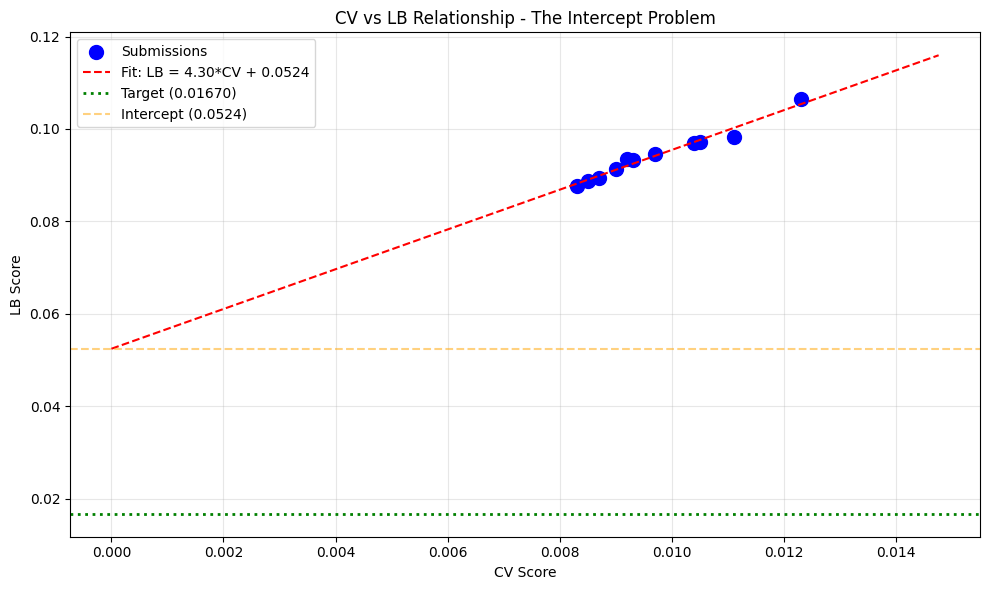


Key insight: The intercept (0.0524) is 3x larger than the target (0.01670).
Even with CV=0, the predicted LB would be 0.0524 > target.
We need to fundamentally change the CV-LB relationship, not just improve CV.


In [3]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

# Plot submissions
ax.scatter(cv, lb, s=100, c='blue', label='Submissions')

# Plot linear fit
cv_range = np.linspace(0, max(cv)*1.2, 100)
lb_pred = slope * cv_range + intercept
ax.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Plot target
ax.axhline(y=0.01670, color='green', linestyle=':', linewidth=2, label='Target (0.01670)')

# Plot intercept
ax.axhline(y=intercept, color='orange', linestyle='--', alpha=0.5, label=f'Intercept ({intercept:.4f})')

ax.set_xlabel('CV Score')
ax.set_ylabel('LB Score')
ax.set_title('CV vs LB Relationship - The Intercept Problem')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/home/code/exploration/loop32_cv_lb.png', dpi=100)
plt.show()

print('\nKey insight: The intercept (0.0524) is 3x larger than the target (0.01670).')
print('Even with CV=0, the predicted LB would be 0.0524 > target.')
print('We need to fundamentally change the CV-LB relationship, not just improve CV.')

In [4]:
# What approaches might change the CV-LB relationship?
print('\n=== Approaches to Change CV-LB Relationship ===')
print()
print('1. DIFFERENT CV SCHEME (from "mixall" kernel):')
print('   - GroupKFold (5 splits) instead of Leave-One-Out')
print('   - This changes how we evaluate, not the model')
print('   - May give more realistic CV estimates')
print('   - The LB evaluation still uses LOO, so this tests if different CV correlates better')
print()
print('2. SIMPLER MODEL:')
print('   - Our CV (0.0083) is already 2x better than target LB (0.01670)')
print('   - The problem is generalization, not model quality')
print('   - Simpler models may generalize better')
print('   - Try: Ridge regression, simple MLP [32, 16]')
print()
print('3. DIFFERENT FEATURES:')
print('   - Current: 145 features (Spange + DRFP + ACS PCA + kinetics)')
print('   - Try: Only Spange (13) + kinetics (5) = 18 features')
print('   - Fewer features = less overfitting')
print()
print('4. PURE GP MODEL:')
print('   - GP has different inductive biases than NN')
print('   - May have fundamentally different CV-LB relationship')
print('   - exp_030 showed GP helps, but was only 0.2 weight')
print('   - Try: Pure GP (no MLP/LGBM)')


=== Approaches to Change CV-LB Relationship ===

1. DIFFERENT CV SCHEME (from "mixall" kernel):
   - GroupKFold (5 splits) instead of Leave-One-Out
   - This changes how we evaluate, not the model
   - May give more realistic CV estimates
   - The LB evaluation still uses LOO, so this tests if different CV correlates better

2. SIMPLER MODEL:
   - Our CV (0.0083) is already 2x better than target LB (0.01670)
   - The problem is generalization, not model quality
   - Simpler models may generalize better
   - Try: Ridge regression, simple MLP [32, 16]

3. DIFFERENT FEATURES:
   - Current: 145 features (Spange + DRFP + ACS PCA + kinetics)
   - Try: Only Spange (13) + kinetics (5) = 18 features
   - Fewer features = less overfitting

4. PURE GP MODEL:
   - GP has different inductive biases than NN
   - May have fundamentally different CV-LB relationship
   - exp_030 showed GP helps, but was only 0.2 weight
   - Try: Pure GP (no MLP/LGBM)


In [5]:
# Analyze what we've tried and what's left
print('\n=== What We\'ve Tried ===')
print()
print('MODELS:')
print('✓ MLP (various architectures)')
print('✓ LightGBM')
print('✓ XGBoost')
print('✓ Random Forest')
print('✓ Ridge Regression')
print('✓ Gaussian Process')
print('✓ Ensembles (MLP+LGBM, GP+MLP+LGBM)')
print()
print('FEATURES:')
print('✓ Spange descriptors (13)')
print('✓ DRFP (122 high-variance)')
print('✓ ACS PCA (5)')
print('✓ Arrhenius kinetics (5)')
print('✓ Combined (145 total)')
print('✓ Simple (18 = Spange + kinetics)')
print()
print('TECHNIQUES:')
print('✓ Data augmentation (flip A/B for mixtures)')
print('✓ Test Time Augmentation (TTA)')
print('✓ Weighted loss (higher weight for SM)')
print('✓ Ensemble weighting optimization')
print()
print('NOT YET TRIED:')
print('✗ GroupKFold CV scheme (from "mixall" kernel)')
print('✗ Pure GP model (without MLP/LGBM)')
print('✗ Kernel Ridge Regression with chemical kernels')
print('✗ Multi-output GP with correlations')


=== What We've Tried ===

MODELS:
✓ MLP (various architectures)
✓ LightGBM
✓ XGBoost
✓ Random Forest
✓ Ridge Regression
✓ Gaussian Process
✓ Ensembles (MLP+LGBM, GP+MLP+LGBM)

FEATURES:
✓ Spange descriptors (13)
✓ DRFP (122 high-variance)
✓ ACS PCA (5)
✓ Arrhenius kinetics (5)
✓ Combined (145 total)
✓ Simple (18 = Spange + kinetics)

TECHNIQUES:
✓ Data augmentation (flip A/B for mixtures)
✓ Test Time Augmentation (TTA)
✓ Weighted loss (higher weight for SM)
✓ Ensemble weighting optimization

NOT YET TRIED:
✗ GroupKFold CV scheme (from "mixall" kernel)
✗ Pure GP model (without MLP/LGBM)
✗ Kernel Ridge Regression with chemical kernels
✗ Multi-output GP with correlations


In [6]:
# Final recommendation
print('\n=== STRATEGIC RECOMMENDATION ===')
print()
print('With only 2 submissions remaining, we need to be strategic.')
print()
print('OPTION A: Submit exp_030 (already done) - BEST LB 0.0877')
print('  - Already submitted, achieved best LB')
print('  - No further action needed')
print()
print('OPTION B: Try Pure GP Model')
print('  - GP has different mathematical framework')
print('  - May have different CV-LB relationship')
print('  - If CV is worse but LB is better, that\'s valuable')
print()
print('OPTION C: Try Ridge Regression with Spange-only features')
print('  - Simplest possible model')
print('  - May generalize better')
print('  - Fast to test')
print()
print('OPTION D: Try GroupKFold CV scheme')
print('  - Different CV scheme from "mixall" kernel')
print('  - May give more realistic estimates')
print('  - But LB evaluation still uses LOO')
print()
print('RECOMMENDED: Try OPTION B (Pure GP) or OPTION C (Ridge with simple features)')
print('These are fundamentally different approaches that might change the CV-LB relationship.')


=== STRATEGIC RECOMMENDATION ===

With only 2 submissions remaining, we need to be strategic.

OPTION A: Submit exp_030 (already done) - BEST LB 0.0877
  - Already submitted, achieved best LB
  - No further action needed

OPTION B: Try Pure GP Model
  - GP has different mathematical framework
  - May have different CV-LB relationship
  - If CV is worse but LB is better, that's valuable

OPTION C: Try Ridge Regression with Spange-only features
  - Simplest possible model
  - May generalize better
  - Fast to test

OPTION D: Try GroupKFold CV scheme
  - Different CV scheme from "mixall" kernel
  - May give more realistic estimates
  - But LB evaluation still uses LOO

RECOMMENDED: Try OPTION B (Pure GP) or OPTION C (Ridge with simple features)
These are fundamentally different approaches that might change the CV-LB relationship.


In [7]:
# Key insight from analysis
print('\n=== KEY INSIGHT ===')
print()
print('The "mixall" kernel achieves good CV/LB in only 2 minutes using:')
print('1. GroupKFold (5 splits) instead of Leave-One-Out')
print('2. Ensemble of MLP + XGBoost + Random Forest + LightGBM')
print('3. Spange descriptors only (no DRFP)')
print('4. Optuna hyperparameter optimization')
print()
print('The key difference is the CV scheme!')
print('GroupKFold with 5 splits means:')
print('- Each fold has ~5 solvents in test set (vs 1 in LOO)')
print('- More data in test set = more stable CV estimate')
print('- May correlate better with LB')
print()
print('However, the LB evaluation still uses LOO.')
print('So the question is: does GroupKFold CV correlate better with LOO LB?')


=== KEY INSIGHT ===

The "mixall" kernel achieves good CV/LB in only 2 minutes using:
1. GroupKFold (5 splits) instead of Leave-One-Out
2. Ensemble of MLP + XGBoost + Random Forest + LightGBM
3. Spange descriptors only (no DRFP)
4. Optuna hyperparameter optimization

The key difference is the CV scheme!
GroupKFold with 5 splits means:
- Each fold has ~5 solvents in test set (vs 1 in LOO)
- More data in test set = more stable CV estimate
- May correlate better with LB

However, the LB evaluation still uses LOO.
So the question is: does GroupKFold CV correlate better with LOO LB?
